In [1]:
%matplotlib inline

In [2]:
import pickle
from importlib import reload
import eval_gnn
reload(eval_gnn)
from eval_gnn import eval_gnn, eval_gnn_pure
from eval_next import eval_next
from eval_bit import eval_bit
from eval_rrt import eval_rrt
import numpy as np
from environment import UR5Env, Kuka2Env, SnakeEnv, MazeEnv, KukaEnv
from str2env import str2env
from str2name import str2name
import warnings
warnings.filterwarnings('ignore')
# indexes = np.arange(2000, 3000)

# try:
#     if result_total is None:
#         result_total = {}
# except:
#     result_total = {}

# methods = [('BIT*', eval_bit), ('RRT*', eval_rrt)]

# for name, eval_method in methods:

#     for problem in ['maze2easy', 'maze2hard', 'snake7', 'ur5', 'kuka7', 'kuka13', 'kuka14']:

#         env, indexes = str2env(problem)
#         for seed in [1234, 2341, 3412, 4123]:
#             if (problem, name, str(seed)) in result_total:
#                 continue
#             print(problem, name, seed)
#             result = eval_method(str(env), seed, env, indexes, batch=100, use_tqdm=True)
#             result_total[problem, name, str(seed)] = result

#         results = [result_total[problem, name, str(seed)] for seed in [1234, 2341, 3412, 4123]]
#         print(problem, name, 'Avg')
#         print('success rate:', np.mean([result[0] for result in results]))
#         print('collision check: %.2f' % np.mean([result[1] for result in results]))
#         print('running time: %.2f' % np.mean([result[2] for result in results]))
#         print('path cost: %.2f' % np.mean([result[3] for result in results]))
#         print('total time: %.2f' % np.mean([result[4] for result in results]))
#         print('')
#         result_total[problem, name, 'Avg'] = tuple([np.mean([result[i] for result in results]) for i in range(5)])
#         results = []

In [16]:
from eval_bit import eval_lazysp
env, indexes = str2env('ur5')
env.init_new_problem(1)
lazy_sp = LazySP(env)
nodes, collisions, path, n_sample, total_time = lazy_sp.plan()

from eval_gnn import path_cost
from config import set_random_seed
from tqdm import tqdm

NameError: name 'LazySP' is not defined

In [ ]:
_ = eval_lazysp('ur5', 1234, env, indexes, batch=100, t_max=100, use_tqdm=True)

100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s]

success rate: 745
collision check: 1281.52
running time: 0.13
path cost: 8.89
total time: 157.34



In [18]:
_ = eval_gnn('ur5', 1234, env, indexes, batch=100, t_max=100, k=10, use_tqdm=True)

gnn 0.01s, search 0.29s, explored 2: 100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]

success rate: 741
collision check: 2647.89
collision check explore: 1436.05
running time: 0.25
path cost: 7.40
total time: 267.51
total time explore: 182.87



In [129]:
env.init_new_problem(0)
env.map[1:-1,1:-1] = 0
env.map[10, 4:10] = 1
env.map[11, 4:10] = 1
env.map[4, 4:10] = 1
env.map[3, 4:10] = 1
env.map[3:12, 10] = 1
env.map[3:12, 9] = 1
env.map[3:11, 8] = 1

In [130]:
import numpy as np
# (array([-0.85735603,  0.57040995]), array([-0.22299576, -0.28646506]))
env.init_state = np.array([-0.,  -0.08646506])
env.goal_state = np.array([-0.,  0.57040995])

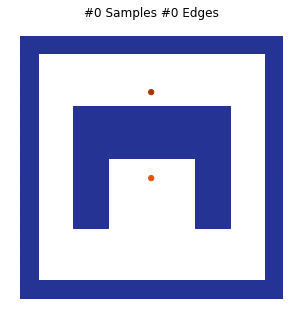

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.plot import plot_edges
plot_edges({}, {}, env.get_problem(), save='wall.png')

In [25]:
import torch
import numpy as np
from torch_geometric.data import Data
from config import set_random_seed
from tqdm import tqdm as tqdm
from torch_sparse import coalesce
from torch_geometric.nn import knn_graph
from time import time
from smoother import model_smooth, proposed_path_smoother, joint_smoother, interpolate_path
from str2name import str2name
from eval_gnn import explore

from str2env import str2env
env, indexes = str2env('maze2hard')
cs = []
bs = 100
result_gnns = []
result_sps = []

for i in tqdm(range(1000)):
    
    env.init_new_problem(i)

    str = 'maze2'
    set_random_seed(1234)
    _, model, model_path, _, _ = str2name(str)
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    _, _, _, model_s, model_s_path = str2name(str)
    model_s.load_state_dict(torch.load(model_s_path, map_location=torch.device("cpu")))

    model.eval()
    model_s.eval()
    result = explore(env, model, model_s, smooth=True, batch=bs, t_max=bs, k=10) 

    from algorithm.lazy_sp import LazySP
    set_random_seed(1234)
    lazy_sp = LazySP(env, batch_size=bs, T=bs)
    result_sp = lazy_sp.plan()
    
    result_gnns.append(result)
    result_sps.append(result_sp)

100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]


In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.plot import plot_edges, merge_pic
paths = []
for i in range(1000):
    if len(result_gnns[i]['path'])==0 or len(result_sps[i][2])==0:
        continue
    if 0.55 * result_gnns[i]['c_explore'] > result_sps[i][1]:
#         print(i, result_gnns[i]['c_explore'], result_sps[i][1])
        env.init_new_problem(i)
        edges = result_gnns[i]['data'].v[np.array(result_gnns[i]['explored_edges']).reshape(-1)].reshape(-1, 2, 2)
        edges = [[tuple(k), tuple(v)] for k, v in zip(edges[:, 0, :].cpu().numpy(), edges[:, 1, :].cpu().numpy())]
        plot_edges(result_gnns[i]['path'], edges, env.get_problem(), \
                   title='GNN explores {0:d} edges'.format(result_gnns[i]['c_explore']), \
                   save='data/images/{0:d}-gnn.png'.format(i))
        plt.show()
        plot_edges(result_sps[i][2], [[result_sps[i][0][k], result_sps[i][0][v]] for set_ in [result_sps[i][5], result_sps[i][6]] for k, v in set_ ], \
                   env.get_problem(), title='LazySP explores {0:d} edges'.format(result_sps[i][1]), \
                   save='data/images/{0:d}-lazy.png'.format(i))
        plt.show()
        paths.extend(['data/images/{0:d}-gnn.png'.format(i), 'data/images/{0:d}-lazy.png'.format(i)])
        print('-------------------------------')

-------------------------------


In [44]:
len(paths)

8

In [49]:
merge_pic(paths, 2, 1, 'data/images/2dhard_lazy.png')

In [5]:
result_gnns[i]['explored_edges']

[[0, 0],
 [0, 51],
 [51, 0],
 [0, 91],
 [91, 0],
 [0, 49],
 [49, 0],
 [0, 27],
 [27, 0],
 [27, 30],
 [30, 27],
 [27, 48],
 [48, 27],
 [27, 9],
 [9, 27],
 [27, 75],
 [75, 27],
 [27, 51],
 [51, 27],
 [0, 86],
 [86, 0],
 [86, 48],
 [48, 86],
 [86, 51],
 [51, 86],
 [86, 49],
 [49, 86],
 [0, 17],
 [17, 0],
 [17, 51],
 [51, 17],
 [17, 91],
 [91, 17],
 [17, 49],
 [49, 17],
 [86, 90],
 [90, 86],
 [90, 72],
 [72, 90],
 [72, 13],
 [13, 72],
 [13, 100],
 [100, 13],
 [13, 55],
 [55, 13],
 [13, 60],
 [60, 13],
 [13, 98],
 [98, 13],
 [72, 2],
 [2, 72],
 [2, 54],
 [54, 2],
 [2, 93],
 [93, 2],
 [2, 43],
 [43, 2],
 [2, 22],
 [22, 2],
 [2, 98],
 [98, 2],
 [2, 60],
 [60, 2],
 [72, 84],
 [84, 72],
 [84, 98],
 [98, 84],
 [84, 60],
 [60, 84],
 [84, 96],
 [96, 84],
 [96, 98],
 [98, 96],
 [96, 60],
 [60, 96],
 [96, 28],
 [28, 96],
 [84, 28],
 [28, 84],
 [72, 28],
 [28, 72],
 [2, 28],
 [28, 2],
 [90, 33],
 [33, 90],
 [33, 48],
 [48, 33],
 [48, 93],
 [93, 48],
 [48, 6],
 [6, 48],
 [48, 43],
 [43, 48],
 [48, 22]

<AxesSubplot:>

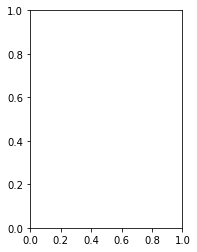

In [13]:
plt.subplot(1, 2)

TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

<Figure size 432x288 with 0 Axes>

In [162]:
result_gnns[i]['path']

[array([ 0.6352847 , -0.25574026], dtype=float32),
 array([ 0.5239478 , -0.14958164], dtype=float32),
 array([0.43289623, 0.00171848], dtype=float32),
 array([0.48086154, 0.12859489], dtype=float32),
 array([0.5583276 , 0.19830956], dtype=float32),
 array([0.7007331 , 0.30573872], dtype=float32),
 array([0.7671286 , 0.40555128], dtype=float32),
 array([0.7862296 , 0.55176246], dtype=float32),
 array([0.78377336, 0.62070644], dtype=float32),
 array([0.7278602, 0.7975414], dtype=float32),
 array([0.52320784, 0.8288062 ], dtype=float32),
 array([0.28823224, 0.82888955], dtype=float32)]

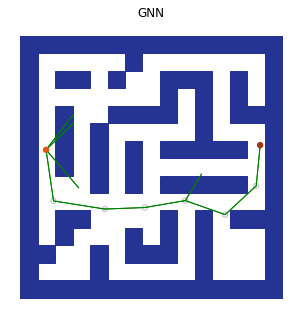

In [10]:
fig1

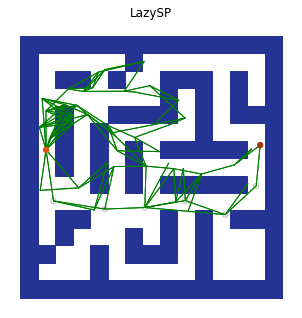

In [11]:
fig2

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

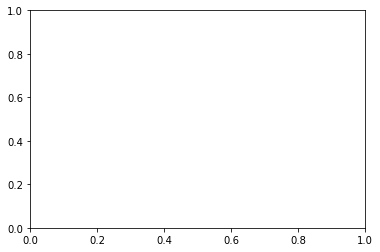

In [9]:
plt.plot(bs, cs)
plt.xlabel('batch size')
plt.ylabel('collision checks')
plt.legend(['GNN', 'LazySP'])
plt.savefig('./lazysp.png')

In [69]:
from eval_gnn import eval_gnn, eval_gnn_pure
methods = [('LazySP*', eval_lazysp)]
seeds = [1234, 2341, 3412, 4123]

try:
    if result_total is None:
        result_total = {}
except:
    result_total = {}

for problem in ['maze2easy', 'maze2hard', 'snake7', 'ur5', 'kuka7', 'kuka13', 'kuka14']:
    
    for name, eval_method in methods:

        env, indexes = str2env(problem)
        for seed in seeds:
            if (problem, name, str(seed)) in result_total:
                continue
            print(problem, name, seed)
            result = eval_method(str(env), seed, env, indexes, use_tqdm=True, batch=100, k=10)
            result_total[problem, name, str(seed)] = result

        results = [result_total[problem, name, str(seed)] for seed in seeds]
        print(problem, name, 'Avg')
        print('success rate:', np.mean([result[0] for result in results]))
        print('collision check: %.2f' % np.mean([result[1] for result in results]))
        print('running time: %.2f' % np.mean([result[2] for result in results]))
        print('path cost: %.2f' % np.mean([result[3] for result in results]))
        print('total time: %.2f' % np.mean([result[4] for result in results]))
        print('')
        result_total[problem, name, 'Avg'] = tuple([np.mean([result[i] for result in results]) for i in range(5)])
        results = []
        pickle.dump(result_total, open("data/lazy_sp.p", "wb"))

  0%|          | 0/1000 [00:00<?, ?it/s]

maze2easy LazySP* 2341


  0%|          | 3/1000 [00:00<00:51, 19.47it/s]

success rate: 1000
collision check: 347.97
running time: 0.08
path cost: 1.40
total time: 80.88

maze2easy LazySP* 3412


  0%|          | 2/1000 [00:00<01:04, 15.39it/s]

success rate: 1000
collision check: 351.51
running time: 0.08
path cost: 1.37
total time: 84.78

maze2easy LazySP* 4123


100%|██████████| 1000/1000 [01:23<00:00, 11.99it/s]


success rate: 1000
collision check: 354.61
running time: 0.08
path cost: 1.40
total time: 82.87

maze2easy LazySP* Avg
success rate: 1000.0
collision check: 351.80
running time: 0.08
path cost: 1.39
total time: 83.65



  0%|          | 0/1000 [00:00<?, ?it/s]

maze2hard LazySP* 2341


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 1000
collision check: 802.53
running time: 0.28
path cost: 2.51
total time: 284.00

maze2hard LazySP* 3412


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 1000
collision check: 791.11
running time: 0.27
path cost: 2.51
total time: 269.29

maze2hard LazySP* 4123


100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


success rate: 1000
collision check: 810.03
running time: 0.30
path cost: 2.50
total time: 299.80

maze2hard LazySP* Avg
success rate: 1000.0
collision check: 801.21
running time: 0.29
path cost: 2.50
total time: 287.30



  0%|          | 0/1000 [00:00<?, ?it/s]

snake7 LazySP* 2341


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 999
collision check: 1568.01
running time: 0.21
path cost: 6.43
total time: 208.81

snake7 LazySP* 3412


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 999
collision check: 1531.01
running time: 0.19
path cost: 6.32
total time: 201.49

snake7 LazySP* 4123


100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s] 


success rate: 998
collision check: 1637.60
running time: 0.19
path cost: 6.42
total time: 267.60

snake7 LazySP* Avg
success rate: 998.75
collision check: 1595.74
running time: 0.20
path cost: 6.40
total time: 236.79



  0%|          | 0/1000 [00:00<?, ?it/s]

ur5 LazySP* 2341


  0%|          | 1/1000 [00:00<02:31,  6.58it/s]

success rate: 987
collision check: 2577.01
running time: 0.50
path cost: 11.62
total time: 780.40

ur5 LazySP* 3412


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 986
collision check: 2862.97
running time: 0.52
path cost: 11.74
total time: 1051.10

ur5 LazySP* 4123


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s] 


success rate: 986
collision check: 2828.67
running time: 0.63
path cost: 11.84
total time: 913.61

ur5 LazySP* Avg
success rate: 987.25
collision check: 2742.12
running time: 0.56
path cost: 11.73
total time: 905.22



  0%|          | 2/1000 [00:00<01:12, 13.69it/s]

kuka7 LazySP* 2341


  0%|          | 2/1000 [00:00<01:11, 13.89it/s]

success rate: 993
collision check: 392.01
running time: 0.11
path cost: 8.95
total time: 408.54

kuka7 LazySP* 3412


  0%|          | 2/1000 [00:00<01:16, 13.12it/s]

success rate: 995
collision check: 342.64
running time: 0.08
path cost: 9.09
total time: 286.77

kuka7 LazySP* 4123


100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s] 


success rate: 994
collision check: 383.10
running time: 0.09
path cost: 8.99
total time: 393.71

kuka7 LazySP* Avg
success rate: 994.0
collision check: 369.36
running time: 0.09
path cost: 8.99
total time: 339.97



  0%|          | 1/1000 [00:00<02:16,  7.31it/s]

kuka13 LazySP* 2341


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 993
collision check: 579.96
running time: 0.19
path cost: 15.81
total time: 391.65

kuka13 LazySP* 3412


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 997
collision check: 499.24
running time: 0.15
path cost: 15.89
total time: 223.37

kuka13 LazySP* 4123


100%|██████████| 1000/1000 [06:18<00:00,  2.65it/s] 


success rate: 994
collision check: 554.55
running time: 0.17
path cost: 15.92
total time: 341.32

kuka13 LazySP* Avg
success rate: 994.75
collision check: 546.64
running time: 0.17
path cost: 15.90
total time: 301.63



  0%|          | 2/1000 [00:00<01:07, 14.90it/s]

kuka14 LazySP* 2341


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 995
collision check: 556.95
running time: 0.18
path cost: 16.10
total time: 376.13

kuka14 LazySP* 3412


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 991
collision check: 637.25
running time: 0.19
path cost: 16.14
total time: 526.86

kuka14 LazySP* 4123


100%|██████████| 1000/1000 [10:29<00:00,  1.59it/s] 


success rate: 993
collision check: 648.10
running time: 0.28
path cost: 16.20
total time: 585.36

kuka14 LazySP* Avg
success rate: 993.25
collision check: 604.64
running time: 0.25
path cost: 16.13
total time: 465.30



<Figure size 432x288 with 0 Axes>

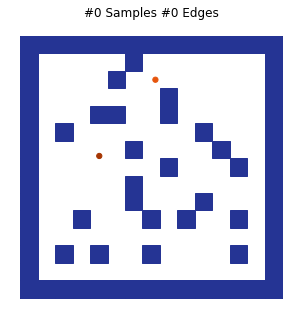

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.plot import plot_edges
plot_edges({}, {}, env.get_problem())
plt.show()

In [1]:
import pickle
from importlib import reload
import eval_gnn
reload(eval_gnn)
from eval_gnn import eval_gnn, eval_gnn_pure
from eval_next import eval_next
from eval_bit import eval_bit
from eval_rrt import eval_rrt
import numpy as np
from environment import UR5Env, Kuka2Env, SnakeEnv, MazeEnv, KukaEnv
from str2env import str2env
from str2name import str2name
import warnings
warnings.filterwarnings('ignore')
indexes = np.arange(2000, 3000)
try:
    if result_total is None:
        result_total = {}
except:
    result_total = {}
    
methods = [('GNN', eval_gnn), ('GNN_pure', eval_gnn_pure)]
seeds = [1234]


for name, eval_method in methods:

    for problem in ['maze2easy', 'maze2hard', 'snake7', 'ur5', 'kuka7', 'kuka13', 'kuka14']:

        env, indexes = str2env(problem)
        for seed in seeds:
            if (problem, name, str(seed)) in result_total:
                continue
            print(problem, name, seed)
            result = eval_method(str(env), seed, env, indexes, use_tqdm=True, batch=100, k=10)
            result_total[problem, name, str(seed)] = result

        results = [result_total[problem, name, str(seed)] for seed in seeds]
        print(problem, name, 'Avg')
        print('success rate:', np.mean([result[0] for result in results]))
        print('collision check: %.2f' % np.mean([result[1] for result in results]))
        print('running time: %.2f' % np.mean([result[2] for result in results]))
        print('path cost: %.2f' % np.mean([result[3] for result in results]))
        print('total time: %.2f' % np.mean([result[4] for result in results]))
        print('')
        result_total[problem, name, 'Avg'] = tuple([np.mean([result[i] for result in results]) for i in range(5)])
        results = []

#         pickle.dump(result_total, open("data/gnn_new_env.p", "wb"))

maze2easy GNN 1234


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 999
collision check: 484.92
collision check explore: 339.85
running time: 0.06
path cost: 1.33
total time: 57.37
total time explore: 42.57

maze2easy GNN Avg
success rate: 999.0
collision check: 484.92
running time: 0.06
path cost: 1.33
total time: 57.37

maze2hard GNN 1234


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 1000
collision check: 1010.93
collision check explore: 709.08
running time: 0.12
path cost: 2.43
total time: 117.64
total time explore: 96.58

maze2hard GNN Avg
success rate: 1000.0
collision check: 1010.93
running time: 0.12
path cost: 2.43
total time: 117.64

snake7 GNN 1234


gnn 0.01s, search 0.27s, explored 2: 100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s] 


success rate: 1000
collision check: 2791.41
collision check explore: 1559.98
running time: 0.31
path cost: 5.41
total time: 305.39
total time explore: 213.50

snake7 GNN Avg
success rate: 1000.0
collision check: 2791.41
running time: 0.31
path cost: 5.41
total time: 305.39

ur5 GNN 1234


gnn 0.01s, search 0.26s, explored 2: 100%|██████████| 1000/1000 [08:59<00:00,  1.85it/s] 


success rate: 959
collision check: 5268.62
collision check explore: 2517.51
running time: 0.44
path cost: 9.26
total time: 497.69
total time explore: 309.97

ur5 GNN Avg
success rate: 959.0
collision check: 5268.62
running time: 0.44
path cost: 9.26
total time: 497.69

kuka7 GNN 1234


gnn 0.01s, search 0.17s, explored 28: 100%|██████████| 1000/1000 [01:50<00:00,  9.08it/s]


success rate: 989
collision check: 457.40
collision check explore: 341.71
running time: 0.05
path cost: 6.61
total time: 86.75
total time explore: 70.54

kuka7 GNN Avg
success rate: 989.0
collision check: 457.40
running time: 0.05
path cost: 6.61
total time: 86.75

kuka13 GNN 1234


gnn 0.01s, search 0.09s, explored 6: 100%|██████████| 1000/1000 [03:02<00:00,  5.48it/s] 


success rate: 990
collision check: 747.97
collision check explore: 455.55
running time: 0.12
path cost: 10.57
total time: 146.61
total time explore: 105.17

kuka13 GNN Avg
success rate: 990.0
collision check: 747.97
running time: 0.12
path cost: 10.57
total time: 146.61

kuka14 GNN 1234


gnn 0.00s, search 0.03s, explored 7:   0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 991
collision check: 681.02
collision check explore: 395.83
running time: 0.09
path cost: 10.41
total time: 113.66
total time explore: 78.23

kuka14 GNN Avg
success rate: 991.0
collision check: 681.02
running time: 0.09
path cost: 10.41
total time: 113.66

maze2easy GNN_pure 1234


  0%|          | 0/1000 [00:00<?, ?it/s]

success rate: 999
collision check: 555.64
collision check explore: 333.73
running time: 0.05
path cost: 1.66
total time: 53.38
total time explore: 35.77

maze2easy GNN_pure Avg
success rate: 999.0
collision check: 555.64
running time: 0.05
path cost: 1.66
total time: 53.38

maze2hard GNN_pure 1234


gnn 0.00s, search 0.11s, explored 56:  18%|█▊        | 176/1000 [00:21<01:41,  8.13it/s] 


KeyboardInterrupt: 